In [2]:
import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter
import copy

In [3]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [4]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [5]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [6]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [7]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
# create_specific_patterns4(0,1,2,4,N)

In [8]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [9]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [10]:
def compute_hamiltonian(all_pat,y):

    H = 0

    for p,yi in zip(all_pat,y):

        if yi==0:
            continue
        
        ops = []
        for t in p:
            if t == [0,1]:
                coefs = [1/2,-1/2]
            elif t == [1,0]:
                coefs = [1/2,1/2]
            else:
                coefs = [1,0]
            ops.append(SparsePauliOp(["I","Z"],coefs))
        op = ops[0]
        for i in range(1,len(ops)):
            op = op.tensor(ops[i]).simplify()
        H = (H + (op * yi[0])).simplify()

    # H = H.simplify(atol=1, rtol=0)

    return np.real_if_close(H.coeffs),H.paulis

# H,paulis_idx = compute_hamiltonian(all_pat,y)
# for pstring,coef in zip(paulis_idx,H):
#     print(pstring,coef)

In [11]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']

In [12]:
def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
    # print(avg/sum_count)    
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                elif len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                elif len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])
                elif len(idx)==4:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[2],idx[3])
                    qc.rz(2*gamma[irep]*coef,idx[3])
                    qc.cnot(idx[2],idx[3])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(paulis_idx,H,shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

Number of qubit needed: 8


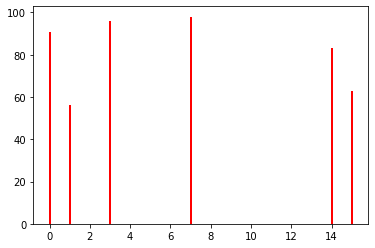

In [13]:
m = 5                       #Number of modes
a = 3                       #Number of possible values
N = int(np.log2(a**m))+1    #Number of qubits for encoding

s = 6                       #Sparsity
print("Number of qubit needed:",N)

#Random sparse spectrum
spec = np.arange(20)
np.random.shuffle(spec)
spec = list(spec[:s])
spec.sort()
spec_val = np.random.randint(50,100,s)

bin_spec = []
for x in spec:
    bin_x = "{0:b}".format(x)
    bin_spec.append('0'*(N-len(bin_x)) + bin_x)

plt.bar(spec,spec_val,width=0.1,color='r')
plt.show()

In [37]:
# pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 
# # all_pat = create_specific_patterns3(0,1,2,N)+create_specific_patterns3(0,1,3,N) + create_specific_patterns3(0,1,4,N) + create_specific_patterns3(0,1,5,N) + create_specific_patterns3(1,2,3,N) + create_specific_patterns3(1,2,5,N) + create_specific_patterns3(2,4,5,N)
# # all_pat = create_specific_patterns(0,2,N) + create_specific_patterns(0,3,N) + create_specific_patterns(1,3,N)

# l = np.arange(0,N)
# all_pat = []
# # for i in range(10):
# #     np.random.shuffle(l)
# #     r = l[0:3]
# #     r.sort()
# #     all_pat += create_specific_patterns3(r[0],r[1],r[2],N)

# for i in range(10):
#     np.random.shuffle(l)
#     r = l[0:4]
#     r.sort()
#     all_pat += create_specific_patterns4(r[0],r[1],r[2],r[3],N)

y = []
for p in all_pat:
    y.append(np.sum([overlapp(p,pat)*val for pat,val in zip(pat_spec,spec_val)]))
y = np.matrix(y).T

A = np.matrix([ dev_pattern(p) for p in all_pat])

print(y)
# print( np.argmax(A.T * y))
# print( (A.T*y).shape)
# print((A.T*y))
# ham_spec = np.zeros(len(dev_pattern(all_pat[0])))
# for yi,pat in zip(y,all_pat):
#     ham_spec+= dev_pattern(pat)*yi
# plt.plot(np.arange(len(dev_pattern(all_pat[0]))),ham_spec)
# plt.show()

# plt.plot(np.arange(50),ham_spec[:50])
# plt.show()

[[243]
 [ 98]
 [  0]
 [146]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 91]
 [ 56]
 [  0]
 [ 96]
 [  0]
 [  0]
 [ 83]
 [161]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [174]
 [313]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [147]
 [194]
 [  0]
 [146]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 91]
 [152]
 [ 83]
 [161]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 91]
 [ 56]
 [ 83]
 [257]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 91]
 [ 56]
 [  0]
 [ 96]
 [  0]
 [  0]
 [ 83]
 [161]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 91]
 [ 56]
 [  0]
 [ 96]
 [  0]
 [  0]
 [ 83]
 [161]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [147]
 [340]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]

In [115]:
# def find_col(spins_coordinates,y):
#     nn = 2
#     M = 7
#     uplet_ind = np.zeros((nn, M - nn + 1))
#     for hh in range(nn): 
#         uplet_ind[hh,:] = spins_coordinates[hh : M - nn + 1 + hh]
#     ind_val = np.meshgrid(np.ones(M - nn + 1), 2**np.arange(nn))[1][::-1]

#     non_zero_elements = (np.sum(ind_val * uplet_ind, axis = 0) + (2**nn) * np.arange(M - nn + 1)).astype(int)

#     At = np.zeros(len(y)).astype(int)
#     At[non_zero_elements] = 1

#     return At

# find_col(np.zeros(7),y) == A.T[0]

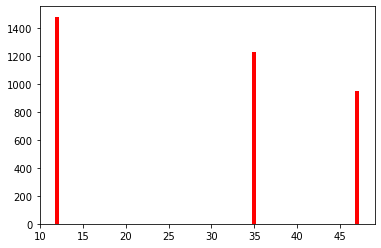

In [66]:
def matching_pursuit(y,A):

    x_recov = {}
    r = copy.deepcopy(y)

    for i in range(10):

        v = np.argmax(A.T * r)

        x_recov[v] = (A.T[v]*r)[0,0] if (v not in x_recov) else x_recov[v]+(A.T[v]*r)[0,0]
        r -= (0.05*((A.T[v]*r)[0,0]) * A.T[v]).T

    return x_recov

x_recov = matching_pursuit(y,A)
x_recov = np.array(list(x_recov.items()))
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()

In [67]:
x_recov = np.zeros((2**N,1))

H, paulis_idx = compute_hamiltonian(all_pat,y)

expectation = get_expectation(paulis_idx=paulis_idx,H=H)

res = minimize(expectation, 
                np.ones(30), 
                method='COBYLA')
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,paulis_idx,H)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

z = list(counts.keys())[np.argmax(list(counts.values()))]
v = BitArray(bin='0'+z).int
print(v)
good_v = v

possible_s = np.arange(0.01,0.05,0.005)

for i in range(10):

    x_recov[good_v] = A.T[good_v]*y
    values = []

    for s in possible_s:
        
        y_prime = np.array(y - (s*((A.T[v]*y)[0,0]) * A.T[v]).T)
        H, paulis_idx = compute_hamiltonian(all_pat,y_prime)

        expectation = get_expectation(paulis_idx=paulis_idx,H=H)
        res = minimize(expectation, 
                        np.ones(30), 
                        method='COBYLA')

        qc_res = create_qaoa_circ(res.x,paulis_idx,H)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        z = list(counts.keys())[np.argmax(list(counts.values()))]
        v = BitArray(bin='0'+z).int
        
        values.append(v)
    
    print(values)
    c = Counter(values)
    ma = max(c, key=c.get)
    values = np.array(values)

    good_s = possible_s[np.where(values==ma)]
    good_s = np.max(good_s)
    
    y -= (0.05*((A.T[good_v]*y)[0,0]) * A.T[v]).T
    good_v = ma
    print(good_v)

x_recov[good_v] = A.T[good_v]*y

x_recov = list(x_recov.T[0])[:a**m]
plt.bar(range(a**m),x_recov)
plt.plot()

35


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 